In [ ]:
from IPython.display import clear_output

In [ ]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [ ]:
import torch
import torch.nn as nn

from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_tensor, to_pil_image, resize

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

#Contents:

1. We'll make a classifier for CIFAR10 dataset in pytorch using a NN architecture

About CIFAR10:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


You need to know:

1. **torch** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

# Downloading the dataset

In [ ]:
from torchvision import transforms
dataset_root = 'data/'

data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root=dataset_root, train=True, download=True, transform=data_transform)
val_dataset = CIFAR10(root=dataset_root, train=False, download=True, transform=data_transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 43704452.14it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

Length of train_dataset is 50000
Length of val_dataset is 10000


In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Implement the Network

In [ ]:
class NN(nn.Module):
    def __init__(self, ni, no):
        super(NN, self).__init__()

        self.layer1 = nn.Linear(ni, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, no)

        self.hidden_activation = nn.ReLU()

    def forward(self, x):

        x = self.hidden_activation(self.layer1(x))
        x = self.hidden_activation(self.layer2(x))
        x = self.hidden_activation(self.layer3(x))
        x = self.hidden_activation(self.layer4(x))
        x = self.layer5(x)

        return x


In [ ]:
WIDTH=32
HEIGHT=32
device = 'cuda'
epochs = 20
lr = 1e-4

train_losses = []
val_losses = []

model = NN(ni=WIDTH*HEIGHT, no=10)

optimizer = Adam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
model.to(device)

NN(
  (layer1): Linear(in_features=1024, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=64, bias=True)
  (layer6): Linear(in_features=64, out_features=10, bias=True)
  (hidden_activation): ReLU()
)

In [ ]:
%%time
for epoch_num in range(epochs):
    model.train()

    epoch_losses = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.view(-1, WIDTH*HEIGHT).to(device)
        batch_y = batch_y.to(device)

        batch_y_preds = model(batch_x)

        loss = criterion(batch_y_preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses += (len(batch_y)*loss.item())

    epoch_loss = epoch_losses/len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    correctly_labelled = 0
    with torch.no_grad():
        val_epoch_losses = 0
        for val_batch_x, val_batch_y in val_loader:
            val_batch_x = val_batch_x.view(-1, WIDTH*HEIGHT).to(device)
            val_batch_y = val_batch_y.to(device)

            val_batch_y_preds = model(val_batch_x)
            val_loss = criterion(val_batch_y_preds, val_batch_y)
            val_epoch_losses += (len(val_batch_y)*val_loss.item())

            correctly_labelled += (val_batch_y_preds.argmax(dim=1) == val_batch_y).sum().item()

        val_epoch_loss = val_epoch_losses/len(val_loader.dataset)
        val_losses.append(val_epoch_loss)

    print(f'Epoch: {epoch_num}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')
print('Training Done')


Epoch: 0, train_loss=2.1257618060684202, val_loss=2.042176940536499. labelled 2415/10000 correctly (24.15% accuracy)
Epoch: 1, train_loss=1.994374637298584, val_loss=1.9637459308624268. labelled 2887/10000 correctly (28.87% accuracy)
Epoch: 2, train_loss=1.9155167639160156, val_loss=1.885334030342102. labelled 3226/10000 correctly (32.26% accuracy)
Epoch: 3, train_loss=1.8524674214935302, val_loss=1.835791297531128. labelled 3412/10000 correctly (34.12% accuracy)
Epoch: 4, train_loss=1.8034825946044921, val_loss=1.7802491426467895. labelled 3584/10000 correctly (35.839999999999996% accuracy)
Epoch: 5, train_loss=1.7624145903778077, val_loss=1.758957271194458. labelled 3659/10000 correctly (36.59% accuracy)
Epoch: 6, train_loss=1.7248065029907227, val_loss=1.7244363700866698. labelled 3794/10000 correctly (37.940000000000005% accuracy)
Epoch: 7, train_loss=1.691745566253662, val_loss=1.7149509395599365. labelled 3801/10000 correctly (38.01% accuracy)
Epoch: 8, train_loss=1.6606685017395

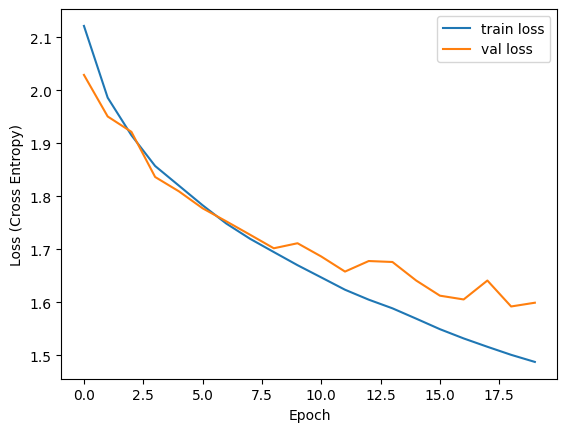

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()